Populating the interactive namespace from numpy and matplotlib


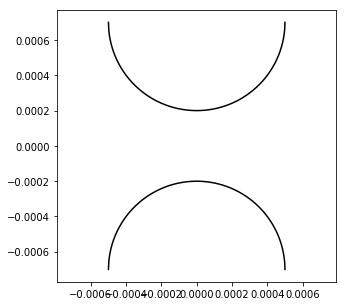

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as syp
from ipywidgets import interact
%pylab inline
pylab.rcParams['figure.figsize'] = (5, 5)

x, R, rt, s, t = syp.symbols('x, R, rt, s, t')

fiberRad = 5e-4
throatRad = 2e-4
points = np.linspace(-fiberRad, fiberRad, 1001)
y = R*syp.sqrt(1- (x/R)**2)
r = rt + (R-y)
rx = syp.lambdify((x, R, rt), r, 'numpy')

def plot_arc(ax, arc_cen, arc_rad, arc_angle, num_points=100):
    r'''
    plot the meniscus arc from neg to pos angle
    '''
    angles = np.linspace(-arc_angle, arc_angle, num_points)
    x = arc_cen - arc_rad*np.cos(angles)
    y = arc_rad*np.sin(angles)
    print(x)
    print(y)
    ax.plot(x, y, 'b-')
    
def plot_fibers(ax, points, fiberRad, throatRad):
    ax.plot(points, rx(points, fiberRad, throatRad), 'k-')
    ax.plot(points, -rx(points, fiberRad, throatRad), 'k-')
    ax.axis('equal')

fig, ax = plt.subplots()
plot_fibers(ax, points, fiberRad, throatRad)

C:\Users\Tom\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """


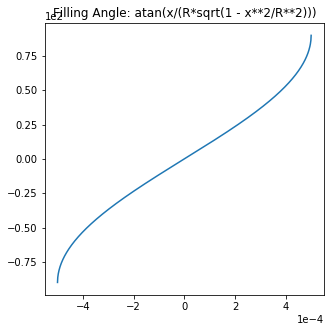

-90.0
atan(x/(R*sqrt(1 - x**2/R**2)))


In [2]:
rprime = r.diff(x)
alpha = syp.atan(rprime)
fill_angle = syp.lambdify((x, R, rt), alpha, 'numpy')
fig, ax = plt.subplots()
fill = np.rad2deg(fill_angle(points, fiberRad, throatRad))
ax.plot(points, fill)
ax.ticklabel_format(style='sci', axis='both', scilimits=(-6,-6))
plt.title('Filling Angle: ' + str(alpha))
plt.show()
print(fill.min())
print(alpha)

In [3]:
rm = r/syp.cos(alpha+t)
a = syp.sqrt(rm**2 - r**2)
gamma = syp.atan(r/a)
f = -2*s*syp.cos(alpha+t)/r
print(rm)
print(a)
print(gamma)
print(f)

(-R*sqrt(1 - x**2/R**2) + R + rt)/cos(t + atan(x/(R*sqrt(1 - x**2/R**2))))
sqrt(-(-R*sqrt(1 - x**2/R**2) + R + rt)**2 + (-R*sqrt(1 - x**2/R**2) + R + rt)**2/cos(t + atan(x/(R*sqrt(1 - x**2/R**2))))**2)
atan((-R*sqrt(1 - x**2/R**2) + R + rt)/sqrt(-(-R*sqrt(1 - x**2/R**2) + R + rt)**2 + (-R*sqrt(1 - x**2/R**2) + R + rt)**2/cos(t + atan(x/(R*sqrt(1 - x**2/R**2))))**2))
-2*s*cos(t + atan(x/(R*sqrt(1 - x**2/R**2))))/(-R*sqrt(1 - x**2/R**2) + R + rt)


In [4]:
Pc = syp.lambdify((x, R, rt, s, t), f, 'numpy')
rad_curve = syp.lambdify((x, R, rt, s, t), rm, 'numpy')
c2x = syp.lambdify((x, R, rt, s, t), a, 'numpy')
cap_angle = syp.lambdify((x, R, rt, s, t), gamma, 'numpy')

C:\Users\Tom\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """


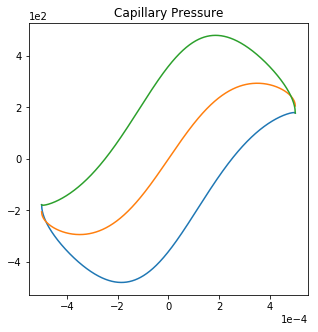

In [5]:
sigma = 0.072
fig, ax = plt.subplots()
for theta in np.deg2rad([60, 90, 120]):
    pressure = Pc(points, fiberRad, throatRad, sigma, theta)
    ax.plot(points, pressure)
ax.ticklabel_format(style='sci', axis='both', scilimits=(-6,-6))
plt.title('Capillary Pressure')
plt.show()

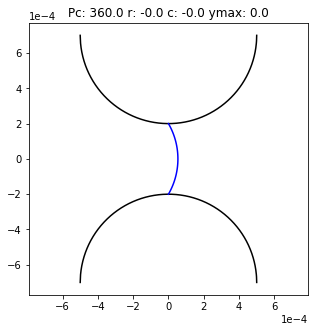

In [6]:
def plot_pos(xpos, throatRad, theta):
    xpos *= fiberRad
    theta = np.deg2rad(theta)
    men_data = {}
    men_data['pos'] = xpos
    men_data['rx'] = rx(xpos, fiberRad, throatRad)
    men_data['alpha'] = fill_angle(xpos, fiberRad, throatRad)
    men_data['c2x'] = c2x(xpos, fiberRad, throatRad, sigma, theta)
    men_data['gamma'] = cap_angle(xpos, fiberRad, throatRad, sigma, theta)
    men_data['radius'] = rad_curve(xpos, fiberRad, throatRad, sigma, theta)
    men_data['center'] = ((xpos) + np.sign(men_data['radius'])*men_data['c2x'])
    men_data['Pc'] = Pc(xpos, fiberRad, throatRad, sigma, theta)
    y_max = men_data['center'] - men_data['radius']
    #print(men_data)
    fig, ax = plt.subplots()
    ax.plot(points, rx(points, fiberRad, throatRad), 'k-')
    ax.plot(points, -rx(points, fiberRad, throatRad), 'k-')
    arc_cen = men_data['center']
    arc_rad = men_data['radius']
    arc_angle = men_data['gamma']
    angles = np.linspace(-arc_angle, arc_angle, 100)
    arcx = arc_cen - arc_rad*np.cos(angles)
    arcy = arc_rad*np.sin(angles)
    ax.plot(arcx, arcy, 'b-')
    ax.axis('equal')
    plt.title('Pc: ' + str(np.around(men_data['Pc'], 1)) +
              ' r: ' + str(np.around(arc_rad, 1)) +
              ' c: ' + str(np.around(arc_cen, 1)) +
              ' ymax: ' + str(np.around(y_max, 1)))
    ax.ticklabel_format(style='sci', axis='both', scilimits=(-6,-6))
    plt.show()

xpos = 3.0e-6    
plot_pos(xpos, throatRad, 120)

In [7]:
interact(plot_pos,
         xpos=(-0.9, 0.9, 0.01),
         throatRad=(1e-4, 25e-4, 1e-5),
         theta=(10, 170, 1))

A Jupyter Widget

<function __main__.plot_pos>

In [8]:
import openpnm as op
import openpnm.models.physics as pm
net = op.network.Cubic(shape=[2, 1, 1], spacing=5e-5)
geo = op.geometry.StickAndBall(network=net,
                               pores=net.pores(),
                               throats=net.throats())
phase = op.phases.Water(network=net)
phase['pore.contact_angle'] = 60
phys = op.physics.Standard(network=net,
                           phase=phase,
                           geometry=geo)
geo['throat.diameter'] = 1e-3
geo['throat.touch_length'] = 5e-4
phys.add_model(propname='throat.max',
               model=pm.meniscus.toroidal,
               mode='max',
               r_toroid=fiberRad)
phys.add_model(propname='throat.touch',
               model=pm.meniscus.toroidal,
               mode='touch',
               r_toroid=fiberRad)
phys.add_model(propname='throat.meniscus',
               model=pm.meniscus.toroidal,
               mode='men',
               r_toroid=fiberRad,
               target_Pc=1000)
touch_Pc = phys['throat.touch'][0]
print(touch_Pc)
max_Pc = phys['throat.max'][0]
print(max_Pc)

C:\Users\Tom\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


73.79035800445364
122.11297889004734


In [9]:
def plot_phys(target_Pc):
    phys.add_model(propname='throat.meniscus',
               model=pm.meniscus.toroidal,
               mode='men',
               r_toroid=fiberRad,
               target_Pc=target_Pc)
    throatRad = geo['throat.diameter'][0]/2
    theta = np.deg2rad(phys['pore.contact_angle'][0])
    men_data = {}
    men_data['pos'] = phys['throat.meniscus.pos']
    men_data['rx'] = phys['throat.meniscus.rx']
    men_data['alpha'] = phys['throat.meniscus.alpha']
    men_data['c2x'] = phys['throat.meniscus.c2x']
    men_data['gamma'] = phys['throat.meniscus.gamma']
    men_data['radius'] = phys['throat.meniscus.radius']
    men_data['center'] = phys['throat.meniscus.center']
    y_max = men_data['center'] - men_data['radius']
    #print(men_data)
    fig, ax = plt.subplots()
    ax.plot(points, rx(points, fiberRad, throatRad), 'k-')
    ax.plot(points, -rx(points, fiberRad, throatRad), 'k-')
    arc_cen = men_data['center']
    arc_rad = men_data['radius']
    arc_angle = men_data['gamma']
    angles = np.linspace(-arc_angle, arc_angle, 100)
    arcx = arc_cen - arc_rad*np.cos(angles)
    arcy = arc_rad*np.sin(angles)
    ax.plot(arcx, arcy, 'b-')
    ax.axis('equal')
    #plt.title(' r: ' + str(np.around(arc_rad, 5)) +
    #          ' c: ' + str(np.around(arc_cen, 5)) +
    #         ' ymax: ' + str(np.around(y_max, 5)))
    ax.ticklabel_format(style='sci', axis='both', scilimits=(-6,-6))
    plt.show()

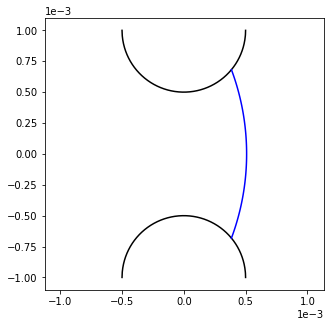

In [10]:
plot_phys(target_Pc=touch_Pc)

In [11]:
interact(plot_phys, target_Pc=(-max_Pc, max_Pc, 10))

A Jupyter Widget

<function __main__.plot_phys>